# Understanding mortality rates in BOP-operated prisons during 2020-2021<br>
NPR obtained a database of people who died in BOP-operated prisons in through Freedom of Information Act requests filed by NPR also requests filed by Professor Alison Guernsey at University of Iowa, shared with NPR. We compared mortality rates during bewteen 2020 and 2021 with previous years, adjusting for age. We found that mortality rates in BOP facilities in 2020 and 2021 have been higher than the five years before the pandemic.<br>

In [71]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import datetime as dt
from datetime import datetime, date
from scipy import interpolate
pd.set_option('display.max_rows', 500)
pd.set_option('use_inf_as_na', True)
os. getcwd()
flatten = lambda t: [item for sublist in t for item in sublist]

### Importing death data
Death data preprocessing see separate notebook

In [72]:
# death data obtained through two FOIA requests
death01 = pd.read_excel('Jan2009-May2021 Deaths Analyzed.xlsx','FOIA JAN 2009 - November 2019')
death02 = pd.read_csv('20211217_2019_2021_deaths.csv')
# death data shared by Alison Guernsey at University of Iowa
death03 = pd.read_csv('20220208_BOP_deaths_Apr_21_Jan_22.csv')

In [73]:
death03 = death03.rename(columns = {'faclCode':'InstID',
                                   'BOP_RegisterNum':'RegisterNum',
                                   'actRelDate':'DOD',
                                   'age':'api_age',
                                   'sex':'api_sex',
                                   'race':'api_race'})

These deaths include privately operated facilities before 2019. We exclude them from the analysis because a) we don't have the post 2019 deaths in privately operated facilities, and b) situations in privately operated facilities are opaque, we have less on-the-ground reporting for them and don't know how similar they are to BOP-operated facilities.

In [74]:
# convert string in the date fields to date time 
def find_date(x):
    try:
        res = pd.to_datetime(x)
    except Exception:
        res = np.nan
    return res

In [75]:
#stitching the three death databases together
deathmasterraw = pd.concat([death01,death02, death03])

In [76]:
deathmasterraw.head()

,,Unnamed: 0,InmateName,InstID,RegisterNum,DOD,DeathType,api_nameLast,api_nameFirst,api_nameMiddle,...,nameFirst,nameMiddle,inmateNum,inmateNumType,releaseCode,faclName,faclType,faclURL,projRelDate,suffix
0,0.0,0,"Calderon, Jamie",OTV,01320-049,2009-01-01 00:00:00,Accidental,calderon,jamie,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2,"Harris, William Jr",BTF,05023-095,2009-01-02 00:00:00,Natural Causes,harris,william,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1,"Shorrt, Darryl",BUH,54731-019,2009-01-02 00:00:00,Natural Causes,shortt,darryl,DENNARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,3,"Wells, John",BUH,01908-036,2009-01-04 00:00:00,Natural Causes,wells,john,JACOB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4,"Kraus, Douglas M.",YAZ,07649-025,2009-01-04 00:00:00,Suicide,kraus,douglas,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# cleaning up the columns as well as dropping duplicates - some of the requests have overlapping timeframes.
deathmaster = deathmasterraw[['InstID','RegisterNum','DOD','api_age','api_sex','api_race']].copy().drop_duplicates()
deathmaster = deathmaster.rename(columns = {'api_age':'age'})
deathmaster.DOD = [find_date(x) for x in deathmaster.DOD]
deathmaster['year'] = [x.year for x in deathmaster.DOD]
deathmaster = deathmaster.drop_duplicates()

In [78]:

deathmaster.head()

,InstID,RegisterNum,DOD,age,api_sex,api_race,year
0,OTV,01320-049,2009-01-01,47.0,Male,White,2009
1,BTF,05023-095,2009-01-02,44.0,Male,Black,2009
2,BUH,54731-019,2009-01-02,53.0,Male,Black,2009
3,BUH,01908-036,2009-01-04,80.0,Male,White,2009
4,YAZ,07649-025,2009-01-04,40.0,Male,White,2009


In [79]:
deathmaster.head()

,InstID,RegisterNum,DOD,age,api_sex,api_race,year
0,OTV,01320-049,2009-01-01,47.0,Male,White,2009
1,BTF,05023-095,2009-01-02,44.0,Male,Black,2009
2,BUH,54731-019,2009-01-02,53.0,Male,Black,2009
3,BUH,01908-036,2009-01-04,80.0,Male,White,2009
4,YAZ,07649-025,2009-01-04,40.0,Male,White,2009


In [80]:
deathmaster.groupby('year').RegisterNum.count()

year
2009    411
2010    402
2011    430
2012    385
2013    433
2014    493
2015    464
2016    397
2017    388
2018    383
2019    383
2020    466
2021    409
2022     17
Name: RegisterNum, dtype: int64

### Importing BOP prison population data
Sources - 
- JSON files collected by UCLA's COVID Behind Bars project
- Bureau of Prisons

#### UCLA's datasets
UCLA ran a scraper that collected json files from the BOP website.

In [81]:
jsonlist = [x for x in os.listdir('ucla_files/')]
pathlist = ['ucla_files/' + x for x in jsonlist]

In [82]:
len(pathlist)

296

In [83]:
# extract the totals and the insitution codes
def parse_json(path):
    f = open(path)
    data = json.load(f)
    df = {}
    df['total_population'] = data['TOTALPOPULATION'][0]
    df['bop_population'] = data['BOPTOTAL'][0]
    df['private_population'] = data['PRIVATETOTAL'][0]
    df['date'] = data['DATEMODIFIED'][0]
    df2 = pd.DataFrame(data['BOP'])
    df2['date'] = data['DATEMODIFIED'][0]
    return df,df2

In [84]:
mainframelst = []
bopfac = []

for path in pathlist:
    try:
        df,df2 = parse_json(path)
        mainframelst.append(df)
        bopfac.append(df2)
    except Exception:
        print(path)

ucla_files/2021-07-20_federal_population.json


In [85]:
#extract population totals
mainframe = pd.DataFrame(mainframelst)
mainframe['population'] = mainframe.bop_population

In [86]:
# examine the insitution codes that have appeared each year - to see if the same set of facilities show up.
bopfacmaster = pd.DataFrame()
for df in bopfac:
     bopfacmaster = bopfacmaster.append(df)
        
bopfacmaster = bopfacmaster.drop_duplicates()
bopfacmaster.date = [pd.to_datetime(x) for x in bopfacmaster.date]
bopfacmaster['year'] = [x.year for x in bopfacmaster.date]

C:\Users\nicho\AppData\Local\Temp\ipykernel_58408\4087333828.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bopfacmaster = bopfacmaster.append(df)
C:\Users\nicho\AppData\Local\Temp\ipykernel_58408\4087333828.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bopfacmaster = bopfacmaster.append(df)
C:\Users\nicho\AppData\Local\Temp\ipykernel_58408\4087333828.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bopfacmaster = bopfacmaster.append(df)
C:\Users\nicho\AppData\Local\Temp\ipykernel_58408\4087333828.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bopfacmaster = bopfacmaster.append(df)
C:\Users\nicho\AppData\Local\Temp\ip

In [87]:
bopfacmaster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18920 entries, 0 to 191
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   code                  18920 non-null  object        
 1   Name                  18920 non-null  object        
 2   state                 18920 non-null  object        
 3   popCount              18920 non-null  int64         
 4   groupDescription      18920 non-null  object        
 5   sortKey               18920 non-null  object        
 6   sortNameKey           18920 non-null  object        
 7   sortpzapSequence      18920 non-null  object        
 8   indentationIndicator  18920 non-null  object        
 9   recordtype            18920 non-null  object        
 10  date                  18920 non-null  datetime64[ns]
 11  year                  18920 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 1.9+ MB


In [88]:
bopfacmaster.info

<bound method DataFrame.info of     code                 Name state  popCount    groupDescription sortKey  \
0    ALD         ALDERSON FPC    WV       948        ALDERSON FPC    0001   
1    ALI       ALICEVILLE FCI    AL      1633      ALICEVILLE FCI    0001   
2    ALI      ALICEVILLE-CAMP    AL       232      ALICEVILLE FCI    0001   
3    ALF    ALLENWOOD LOW FCI    PA      1309   ALLENWOOD LOW FCI    0001   
4    ALM    ALLENWOOD MED FCI    PA      1288   ALLENWOOD MED FCI    0001   
..   ...                  ...   ...       ...                 ...     ...   
187  YAN          YANKTON FPC    SD       303         YANKTON FPC    0001   
188  YAZ  YAZOO CITY FCI-CAMP    MS       137      YAZOO CITY FCI    0001   
189  YAZ       YAZOO CITY FCI    MS      1382      YAZOO CITY FCI    0001   
190  YAM   YAZOO CITY MED FCI    MS      1418  YAZOO CITY MED FCI    0001   
191  YAP       YAZOO CITY USP    MS       634      YAZOO CITY USP    0001   

                sortNameKey sortpzapSequenc

In [89]:
instcnt = pd.DataFrame(bopfacmaster.groupby('year').code.unique())
instcnt['cnt'] = [len(x) for x in instcnt.code]

In [90]:
instcnt.cnt.value_counts()
# seems like it's 122 every year

122    6
121    1
Name: cnt, dtype: int64

In [91]:
allcodes = flatten(instcnt.code)

bopcodes = list(np.unique(np.array(allcodes)))
print(bopcodes)

['ALD', 'ALF', 'ALI', 'ALM', 'ALP', 'ASH', 'ATL', 'ATW', 'BAS', 'BEC', 'BEN', 'BER', 'BIG', 'BML', 'BMM', 'BMP', 'BRO', 'BRY', 'BSY', 'BTF', 'BUF', 'BUH', 'BUT', 'CAA', 'CCC', 'CLP', 'COL', 'COM', 'COP', 'CRW', 'CUM', 'DAN', 'DEV', 'DTH', 'DUB', 'EDG', 'ELK', 'ENG', 'ERE', 'EST', 'FAI', 'FLF', 'FLM', 'FLP', 'FOM', 'FOR', 'FTD', 'FTW', 'GIL', 'GRE', 'GUA', 'HAF', 'HAZ', 'HER', 'HON', 'HOU', 'JES', 'LAT', 'LEE', 'LEW', 'LEX', 'LOF', 'LOM', 'LOR', 'LOS', 'LVN', 'MAN', 'MAR', 'MCD', 'MCK', 'MCR', 'MEM', 'MEN', 'MIA', 'MIL', 'MIM', 'MNA', 'MON', 'MRG', 'NYM', 'OAD', 'OAK', 'OKL', 'OTV', 'OXF', 'PEK', 'PEM', 'PEN', 'PET', 'PHL', 'PHX', 'POL', 'POM', 'RBK', 'RCH', 'SAF', 'SCH', 'SDC', 'SEA', 'SET', 'SHE', 'SPG', 'SST', 'TAL', 'TCN', 'TCP', 'TDG', 'TEX', 'THA', 'THP', 'TOM', 'TRM', 'TRV', 'VIM', 'VIP', 'VVM', 'WAS', 'WIL', 'YAM', 'YAN', 'YAP', 'YAZ']


In [92]:
len(bopcodes)
# and it looks like it's the same 122 facilities

122

In [93]:
# using the BOP codes to filter out deaths in these facilities
deathmaster = deathmaster[deathmaster.InstID.isin(bopcodes)].copy()

In [94]:
deathmaster.info

<bound method DataFrame.info of     InstID RegisterNum        DOD   age api_sex api_race  year
0      OTV   01320-049 2009-01-01  47.0    Male    White  2009
1      BTF   05023-095 2009-01-02  44.0    Male    Black  2009
2      BUH   54731-019 2009-01-02  53.0    Male    Black  2009
3      BUH   01908-036 2009-01-04  80.0    Male    White  2009
4      YAZ   07649-025 2009-01-04  40.0    Male    White  2009
..     ...         ...        ...   ...     ...      ...   ...
281    COM   10193-026 2022-01-13  57.0    Male    Black  2022
282    BUH   72196-080 2022-01-14  47.0    Male    White  2022
283    ALD   15134-088 2022-01-14  30.0  Female    White  2022
284    FTW   24595-004 2021-07-28  74.0    Male    Black  2021
285    DEV   36746-053 2021-10-01  89.0    Male    White  2021

[4922 rows x 7 columns]>

In [95]:
# check if any BOP facility hans't had any deaths
[x for x in bopcodes if x not in deathmaster.InstID.unique()]

['RBK']

#### BOP's datasets
BOP provided the population data broken down by age groups to NPR.<br>
The population totals supplement the json population count, and the age group distribution is used to calculate standardized mortality rate. BOP says these reports aren't necessarily on September 30, but a certain day in September that's close to it

In [96]:
agedist = pd.read_excel('tabula-Age_BOP_FY2015-21_cleaned.xlsx')

In [97]:
agedist.head()

,year,age,Frequency,Percent,Cumulative_x000D_Frequency,Cumulative_x000D_Percent
0,2021,<=19,137,0.10,137,0.10
1,2021,20 - 24,5213,3.97,5350,4.08
2,2021,25 - 29,14452,11.02,19802,15.10
3,2021,30 - 34,22029,16.79,41831,31.89
4,2021,35 - 39,23535,17.94,65366,49.83


In [98]:
# calculate population totals from the BOP dataset
reportcnt = pd.DataFrame(agedist.groupby('year').Frequency.sum())
reportcnt = reportcnt.reset_index()
reportcnt.year = reportcnt.year.astype('str')
reportcnt['date_text'] = ['09/30/' + x for x in reportcnt.year]
reportcnt['date'] = [pd.to_datetime(x) for x in reportcnt.date_text]
reportcnt = reportcnt.rename(columns = {'Frequency':'population'})

In [99]:
reportcnt.head()

,year,population,date_text,date
0,2015,164851,09/30/2015,2015-09-30
1,2016,155858,09/30/2016,2016-09-30
2,2017,153838,09/30/2017,2017-09-30
3,2018,152891,09/30/2018,2018-09-30
4,2019,149298,09/30/2019,2019-09-30


In [100]:
# adding the BOP data to the UCLA data
popdf = pd.concat([mainframe,reportcnt])
popdf.date = [pd.to_datetime(x) for x in popdf.date]
popdf = popdf.drop_duplicates()
popdf = popdf.sort_values('date').reset_index()
popdf = popdf.drop('index', axis = 1)
popdf['year'] = [x.year for x in popdf.date]

In [101]:
popdf.tail()

,total_population,bop_population,private_population,date,population,year,date_text
100,156862.0,134447.0,6580.0,2021-12-02,134447,2021,NaN
101,156850.0,134384.0,6605.0,2021-12-09,134384,2021,NaN
102,157477.0,135033.0,6565.0,2021-12-16,135033,2021,NaN
103,157654.0,135334.0,6508.0,2021-12-30,135334,2021,NaN
104,157472.0,135380.0,6465.0,2022-01-06,135380,2022,NaN


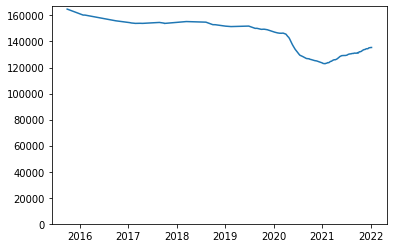

In [102]:
# check to see if the two datasets form a smooth curve. 
plt.plot(popdf.date.to_numpy(), popdf.population.to_numpy())
plt.ylim(bottom=0)
plt.show()

### Computing annualized average prison population
Given prison population decreased significantly over the course of 2020 and 2021, we calculate an annualized average population for every year using all accessible datapoints through out the year. We use linear interpolation and extrapolation to fill in the times when there's no data available.

#### Interpolate/extrapolate Jan 1 and Dec 31 values
To calculate and annualized average, we need to make sure that every year has values for the first and last day of the year. This datapoint doesn't exist for every year, so we use interpolation and extrapolation to fill in the blanks

In [103]:
def get_bookends(year):
    output = []
    yeardf = popdf[popdf.year == year]
    if year == 2015:
#         Interpolate Dec. 31
        if (yeardf.date.iloc[-1].month == 12) & (yeardf.date.iloc[-1].day == 31) == False:
            # if not, then we interpolate
            yearend = popdf[popdf.year == (year + 1)][['date','population']].iloc[0]
            yeardf = yeardf.append(yearend).sort_values('date')
            yeardf = yeardf.reset_index()
            # calculate delta of days between first date of next year and last date of this year
            delta1 = (yeardf.date.iloc[-1]-yeardf.date.iloc[-2]).days
            # calculate delta of days between Dec 31 of this year and last date of this year
            delta2 = (pd.to_datetime('12/31/' + str(year))- yeardf.date.iloc[-2]).days
            # calculate the position of Dec 31
            dec31pos = delta2/delta1
            xp = [0,1]
            fp = [yeardf.population.iloc[-2],yeardf.population.iloc[-1]]
            dec31val = np.interp(dec31pos, xp, fp)
            # append the interpolated value to yeardf
            decdict = {'date':pd.to_datetime('12/31/' + str(year)),'population':dec31val}
            output.append(decdict)
        else:
            dec31val = yeardf.population.iloc[-1]

#         extrapolate Jan1 - since we don't have data for 2014
        if (yeardf.date.iloc[0].month == 1) & (yeardf.date.iloc[0].day == 1) == False:
#             # calculate delta of days between first date of this year and last date of last year
            delta1 = (yeardf.date[0]-pd.to_datetime('01/01/' + str(year))).days
            pos1 = delta1/365
#             # calculate the position of Jan 1
            jan1pos = 0
            xp = [pos1,1] 
            fp = [yeardf.population[0],dec31val]
            f = interpolate.interp1d(xp, fp, fill_value = "extrapolate")
            jan1val = float(f(jan1pos))
            # append the interpolated value to yeardf
            jandict = {'date':pd.to_datetime('01/01/' + str(year)),'population':jan1val}
            output.append(jandict)
        else:
            pass
        
    else: # for the rest of the years, use interpolation only
        if (yeardf.date.iloc[0].month == 1) & (yeardf.date.iloc[0].day == 1) == False:
            yearend = popdf[popdf.year == (year -1)][['date','population']].iloc[-1]
            yeardf1 = yeardf.append(yearend).sort_values('date')
            yeardf1 = yeardf1.reset_index()
            # calculate delta of days between first date of this year and last date of last year
            delta1 = (yeardf1.date[1]-yeardf1.date[0]).days
            # calculate delta of days between Jan 1 of this year and last date of last year
            delta2 = (pd.to_datetime('01/01/' + str(year))- yeardf1.date[0]).days
            # calculate the position of Jan 1
            jan1pos = delta2/delta1
            xp = [0,1]
            fp = [yeardf1.population[0],yeardf1.population[1]]
            jan1val = np.interp(jan1pos, xp, fp)
            # append the interpolated value to yeardf
            jandict = {'date':pd.to_datetime('01/01/' + str(year)),'population':jan1val}
            output.append(jandict)
        else:
            pass
        if (yeardf.date.iloc[-1].month == 12) & (yeardf.date.iloc[-1].day == 31) == False:
            # if not, then we interpolate
            yearend = popdf[popdf.year == (year + 1)][['date','population']].iloc[0]
            yeardf1 = yeardf.append(yearend).sort_values('date')
            yeardf1 = yeardf1.reset_index()
            # calculate delta of days between first date of next year and last date of this year
            delta1 = (yeardf1.date.iloc[-1]-yeardf1.date.iloc[-2]).days
            # calculate delta of days between Dec 31 of this year and last date of this year
            delta2 = (pd.to_datetime('12/31/' + str(year))- yeardf1.date.iloc[-2]).days
            # calculate the position of Dec 31
            dec31pos = delta2/delta1
            xp = [0,1]
            fp = [yeardf1.population.iloc[-2],yeardf1.population.iloc[-1]]
            dec31val = np.interp(dec31pos, xp, fp)
            # append the interpolated value to yeardf
            decdict = {'date':pd.to_datetime('12/31/' + str(year)),'population':dec31val}
            output.append(decdict)
        else:
            pass

    return output

In [104]:
yearsarray = np.arange(2015,2022)
yearsarray

array([2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [105]:
# compute the interpolated values for Jan 1 and Dec. 31 of each year
bookends = []
for year in yearsarray:
    res = get_bookends(year)
    bookends.append(res)

nbookends = flatten(bookends)
nbookendsdf = pd.DataFrame(nbookends)

C:\Users\nicho\AppData\Local\Temp\ipykernel_58408\2004294141.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yeardf = yeardf.append(yearend).sort_values('date')
C:\Users\nicho\AppData\Local\Temp\ipykernel_58408\2004294141.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yeardf1 = yeardf.append(yearend).sort_values('date')
C:\Users\nicho\AppData\Local\Temp\ipykernel_58408\2004294141.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yeardf1 = yeardf.append(yearend).sort_values('date')
C:\Users\nicho\AppData\Local\Temp\ipykernel_58408\2004294141.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yeardf1 = yeardf.append(yearend

In [106]:
print(bookends)
print(len(bookends))

[[{'date': Timestamp('2015-12-31 00:00:00'), 'population': 161335.06666666668}, {'date': Timestamp('2015-01-01 00:00:00'), 'population': 175134.15985663078}], [{'date': Timestamp('2016-01-01 00:00:00'), 'population': 161296.85}, {'date': Timestamp('2016-12-31 00:00:00'), 'population': 154630.15384615384}], [{'date': Timestamp('2017-01-01 00:00:00'), 'population': 154616.8076923077}, {'date': Timestamp('2017-12-31 00:00:00'), 'population': 154637.18072289156}], [{'date': Timestamp('2018-01-01 00:00:00'), 'population': 154645.8674698795}, {'date': Timestamp('2018-12-31 00:00:00'), 'population': 151806.7012987013}], [{'date': Timestamp('2019-01-01 00:00:00'), 'population': 151792.46753246753}, {'date': Timestamp('2019-12-31 00:00:00'), 'population': 147418.4642857143}], [{'date': Timestamp('2020-01-01 00:00:00'), 'population': 147384.85714285713}], [{'date': Timestamp('2021-01-01 00:00:00'), 'population': 123466.57142857143}, {'date': Timestamp('2021-12-31 00:00:00'), 'population': 135340

In [107]:
# add the coomputed bookends to the population counts
popdf1 = pd.concat([popdf,nbookendsdf])
popdf1 = popdf1.sort_values('date')
popdf1.year = [x.year for x in popdf1.date]

In [108]:
yeardf = popdf1[popdf1.year == 2021][['date','population']]
yeardf = yeardf.reset_index()
totalarray = []
days_total = []
for i,r in yeardf.iterrows():
    if i < len(yeardf)-1:
        #print("-----------------------")
        # mean of population between two dates
        #print(yeardf.date.iloc[i], yeardf.population.iloc[i] )
        #print(yeardf.date.iloc[i+1], yeardf.population.iloc[i+1])
        avrpop = (yeardf.population.iloc[i] + yeardf.population.iloc[i+1])/2
        # number of days between two dates
        days = (yeardf.date.iloc[i+1] - yeardf.date.iloc[i]).days
        days_total.append(days)
        #print(avrpop)
        #print(days)
        popbydays = avrpop * days
        #print(popbydays)
        totalarray.append(popbydays)
        #print("--------------------------")
    else:
        continue
sum1 = np.sum(totalarray)
dayinyear = (yeardf.date.max() - yeardf.date.min()).days
print(sum(days_total), "--")
avroutput = sum1/sum(days_total)
print(avroutput)

364 --
129123.92857142857


In [139]:
totalarray

[1699977.4423076923,
 2160550.0,
 3235680.0,
 1077513.5,
 5387095.0,
 3232362.0,
 19434933.0,
 5401532.5,
 307897.0,
 14189858.313253013]

In [140]:
yeardf = popdf1[popdf1.year == 2017][['date','population']]
yeardf = yeardf.reset_index()

sum(yeardf["population"])/len(yeardf["population"])

154191.45349229084

In [141]:
print(yeardf.date.max())
print(yeardf.date.min())
print(yeardf.date.max() - yeardf.date.min())
dayinyear

2017-12-31 00:00:00
2017-01-01 00:00:00
364 days 00:00:00


364

In [ ]:
print(sum1, ":", dayinyear, ":", avroutput)

56127398.75556071 : 364 : 154196.1504273646


#### Calcuate an average yearly population with existing data points

In [ ]:
def avr_yr_pop(year):
    # extract the data points for the year
    yeardf = popdf1[popdf1.year == year][['date','population']]
    yeardf = yeardf.reset_index()
    totalarray = []
    for i,r in yeardf.iterrows():
        if i < len(yeardf)-1:
            # mean of population between two dates
            avrpop = (yeardf.population.iloc[i] + yeardf.population.iloc[i+1])/2
            # number of days between two dates
            days = (yeardf.date.iloc[i+1] - yeardf.date.iloc[i]).days
            popbydays = avrpop * days
            totalarray.append(popbydays)
        else:
            continue
    sum1 = np.sum(totalarray)
    dayinyear = (yeardf.date.max() - yeardf.date.min()).days
    avroutput = sum1/dayinyear
    yrdict = {}
    yrdict['year'] = year
    yrdict['average_pop'] = avroutput
    return yrdict

In [ ]:
avrlist = []

In [ ]:
for year in list(popdf1.year.unique()):
    try:
        res= avr_yr_pop(year)
        avrlist.append(res)
    except Exception:
        continue

C:\Users\nicho\AppData\Local\Temp\ipykernel_12932\1091619577.py:18: RuntimeWarning: invalid value encountered in double_scalars
  avroutput = sum1/dayinyear


In [ ]:
avrpopdf = pd.DataFrame(avrlist)

In [ ]:
avrpopdf

,year,average_pop
0,2015,168248.738481
1,2016,157632.991923
2,2017,154196.150427
3,2018,154201.533271
4,2019,150563.593072
5,2020,134519.627202
6,2021,129123.928571
7,2022,NaN


In [ ]:
agedist.Percent = agedist.Percent.astype('float')
agedist.Percent = agedist.Percent/100

In [ ]:
agedist1 = pd.merge(agedist, avrpopdf, on = 'year', how = 'left' )
agedist1.columns = agedist1.columns.str.lower()
agedist1['group_pop'] = agedist1.percent * agedist1.average_pop

In [ ]:
agedist1.head()

,year,age,frequency,percent,cumulative_x000d_frequency,cumulative_x000d_percent,average_pop,group_pop
0,2021,<=19,137,0.0010,137,0.10,129123.928571,129.123929
1,2021,20 - 24,5213,0.0397,5350,4.08,129123.928571,5126.219964
2,2021,25 - 29,14452,0.1102,19802,15.10,129123.928571,14229.456929
3,2021,30 - 34,22029,0.1679,41831,31.89,129123.928571,21679.907607
4,2021,35 - 39,23535,0.1794,65366,49.83,129123.928571,23164.832786


In [ ]:
agedist1 = agedist1.rename(columns= {'age':'age_group'})
agedist1.age_group = agedist1.age_group.str.replace('-','–')
agedist1.age_group = agedist1.age_group.str.replace(' ','')
agedist1.age_group = agedist1.age_group.str.replace('<=19','0–19')
agedist1.age_group = agedist1.age_group.str.strip()

#### Categorize age groups of each death

In [ ]:
deathmaster['age_group'] = ''

In [ ]:
agegroups = agedist1[['age_group']].copy().drop_duplicates()
agegroups['minage'] = [x.split('–')[0] for x in agegroups.age_group]
agegroups['maxage'] = [x.split('–')[1] for x in agegroups.age_group]
agegroups.minage = agegroups.minage.str.strip()
agegroups.minage = agegroups.minage.astype('float')
agegroups.maxage = agegroups.maxage.str.strip()
agegroups.maxage = agegroups.maxage.astype('float')

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
bins= list(agegroups.minage)
bins.append(150)
labels = list(agegroups.age_group)
deathmaster['age_group'] = pd.cut(deathmaster['age'], bins=bins, labels=labels, right=False)

#### Calculate Mortality year to year
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3406211/

In [ ]:
death_year_age = pd.DataFrame(deathmaster.groupby(['year','age_group']).RegisterNum.count())
death_year_age = death_year_age.reset_index()
death_year_age = death_year_age.rename(columns = {'RegisterNum':'deaths'})

In [ ]:
death_year_age

In [ ]:
agedist2 = pd.merge(agedist1, death_year_age, on = ['age_group','year'], how = 'left')

In [ ]:
agedist2.tail()

,year,age_group,frequency,percent,cumulative_x000d_frequency,cumulative_x000d_percent,average_pop,group_pop,deaths
106,2015,70–74,1282,0.0078,164254,99.64,168248.738481,1312.340160,35
107,2015,75–79,431,0.0026,164685,99.90,168248.738481,437.446720,18
108,2015,80–84,134,0.0008,164819,99.98,168248.738481,134.598991,6
109,2015,85–89,26,0.0002,164845,100.00,168248.738481,33.649748,5
110,2015,90–94,6,0.0000,164851,100.00,168248.738481,0.000000,1


In [ ]:
# calculate death rate for each age group
agedist2['mortality_per_100k'] = agedist2.deaths/agedist2.group_pop * 100000

In [ ]:
df = agedist2.pivot(index = 'age_group', columns = 'year', values = 'mortality_per_100k')

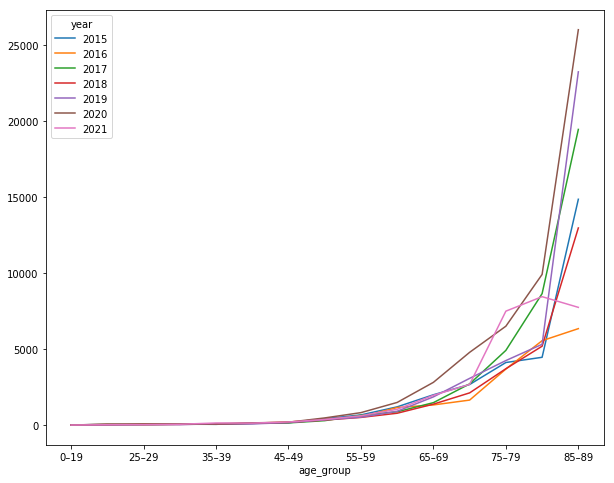

In [49]:
df.plot(figsize=(10, 8))

### Calculate standardized mortality ratio
#### Importing age percentage breakdown of prison population, provided by the BOP

In [86]:
df

year,2015,2016,2017,2018,2019,2020,2021
age_group,,,,,,,
0–19,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
20–24,5.036933e+01,42.386523,0.000000,1.508144e+01,1.530348e+01,56.747019,19.507552
25–29,2.501507e+01,10.862756,33.031814,5.523867e+01,2.276508e+01,65.038140,21.083025
30–34,6.523861e+01,49.531559,52.528474,4.506331e+01,2.492200e+01,49.861252,50.738224
35–39,4.747269e+01,63.639463,48.268712,6.302935e+01,8.435084e+01,85.493455,133.823543
40–44,1.068166e+02,121.142896,111.814590,1.104007e+02,7.439379e+01,142.445211,126.367099
45–49,1.483338e+02,198.245301,139.698758,1.730038e+02,1.627871e+02,185.100114,200.992648
50–54,4.169694e+02,372.729121,287.896444,3.276802e+02,3.425971e+02,467.371946,362.739951
55–59,6.652448e+02,539.902098,645.129204,5.022069e+02,5.159677e+02,816.066902,613.560577


### Compare mortality rates during pandemic and five years prior
#### 2020 to 2015-2019
Using population and mortality between 2015 and 2019 as reference population.<br>
We have also considered using US population as a reference population. Similar to previous studies, we found that expected deaths exceed actual deaths when use the US population as a reference. One of the reasons can be that many causes of death in general population, like car accidents, don't exist in incarcerated environments.

In [87]:
ref = agedist2[agedist2.year < 2020].copy()

In [88]:
ref.head()

,year,age_group,frequency,percent,cumulative_x000d_frequency,cumulative_x000d_percent,average_pop,group_pop,deaths,mortality_per_100k
31,2019,0–19,262,0.0018,262,0.18,150563.593072,271.014468,0,0.000000
32,2019,20–24,6476,0.0434,6738,4.51,150563.593072,6534.459939,1,15.303484
33,2019,25–29,17423,0.1167,24161,16.18,150563.593072,17570.771312,4,22.765079
34,2019,30–34,23870,0.1599,48031,32.17,150563.593072,24075.118532,6,24.921996
35,2019,35–39,27034,0.1811,75065,50.28,150563.593072,27267.066705,23,84.350841


In [89]:
std = pd.DataFrame(ref.groupby('age_group').deaths.sum()/ref.groupby('age_group').group_pop.sum())# that creates 
std.columns = ['expected_death_rate']

In [142]:
std.head()

,expected_death_rate
age_group,
0–19,0.000000
20–24,0.000256
25–29,0.000293
30–34,0.000482
35–39,0.000608


In [90]:
yr20 = agedist2[agedist2.year == 2020].copy()
yr20_1 = yr20[['age_group','group_pop','deaths']]

In [91]:
std1 = pd.merge(std, yr20_1, on = 'age_group')
std1['expected_deaths'] = std1.group_pop * std1.expected_death_rate

In [92]:
std1.head()

,age_group,expected_death_rate,group_pop,deaths,expected_deaths
0,0–19,0.000000,121.067664,0,0.000000
1,20–24,0.000256,5286.621349,3,1.353467
2,25–29,0.000293,15375.593389,10,4.500768
3,30–34,0.000482,22061.218861,11,10.635761
4,35–39,0.000608,24563.283927,21,14.944614


In [93]:
std1.deaths.sum()/std1.expected_deaths.sum()-1

0.5029274867843305

#### Compare 2021  to 2015-2019

In [94]:
yr21 = agedist2[agedist2.year == 2021].copy()
yr21_1 = yr21[['age_group','group_pop','deaths']]

In [95]:
std21 = pd.merge(std, yr21_1, on = 'age_group')
std21['expected_deaths'] = std21.group_pop * std21.expected_death_rate

In [96]:
std21.deaths.sum()/std21.expected_deaths.sum()-1

0.2000471026429107

#### Combining 2020 and 2021

In [97]:
((std21.deaths.sum() + std1.deaths.sum())/2)/((std21.expected_deaths.sum()+std1.expected_deaths.sum())/2)-1

0.3546075752021547